# Markowitz Portfolio Theory: Optimization & Backtesting

This project implements a complete portfolio optimization workflow based on Modern Portfolio Theory (Markowitz, 1952).

- Convex optimization for risk minimization
- Sharpe ratio maximization for the tangency portfolio
- Risk–return trade-off using the Efficient Frontier
- Capital Market Line (CML) construction


### Some tested constraints
- Full-investment constraint 
- Long-only bounds 
- Scenario with capped weights  
- Impact of constraints on the Efficient Frontier


### Backtesting Framework: Cumulative return comparison across
- Global Minimum Variance (GMV) Portfolio
- Tangency Portfolio
- Equal Weight Portfolio

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.optimize import minimize
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings("ignore", message=".*date_parser.*", category=FutureWarning)

## Fetching data from Yahoo Finance

In [2]:
tickers = ["TSLA", "WMT", "BAC", "GS", "LLY", "MRK", "GOOG", "META", "AAPL", "XOM"]

start_date = "2020-07-01"
end_date = "2025-06-30"
test_start_date = "2025-07-01"
test_end_date = "2025-10-30"

df = yf.download(
    tickers, start=start_date, end=end_date,
    auto_adjust=True, progress=False, interval="1d"
)["Close"]

# For the test period
df_test = yf.download(
    tickers, start=test_start_date, end=test_end_date,
    auto_adjust=True, progress=False, interval="1d"
)["Close"]

df_all = pd.concat([df, df_test])
returns_all = df_all.pct_change().dropna()

print(df.shape)
df.head()

(1254, 10)


Ticker,AAPL,BAC,GOOG,GS,LLY,META,MRK,TSLA,WMT,XOM
Date,,,,,,,,,,
2020-07-01,88.299118,20.450159,71.413300,174.300858,153.428162,236.094528,63.182007,74.641998,37.063187,34.208164
2020-07-02,88.299118,20.476540,72.737251,174.150848,153.963684,231.989853,63.715801,80.577332,36.914558,34.497734
2020-07-06,90.661148,20.801836,74.276703,182.937805,156.801132,238.807831,64.362839,91.438667,36.815464,34.740353
2020-07-07,90.379829,20.230362,73.754288,175.880020,156.669601,239.384262,63.667294,92.657333,39.311314,33.840332
2020-07-08,92.484787,20.309490,74.291603,178.429642,158.905716,242.087616,63.020248,91.058670,38.534084,33.762070


In [3]:
rets = df.pct_change().dropna()
print(rets.shape)
rets.head()

(1253, 10)


Ticker,AAPL,BAC,GOOG,GS,LLY,META,MRK,TSLA,WMT,XOM
Date,,,,,,,,,,
2020-07-02,0.000000,0.001290,0.018539,-0.000861,0.003490,-0.017386,0.008449,0.079517,-0.004010,0.008465
2020-07-06,0.026750,0.015886,0.021165,0.050456,0.018429,0.029389,0.010155,0.134794,-0.002684,0.007033
2020-07-07,-0.003103,-0.027472,-0.007033,-0.038580,-0.000839,0.002414,-0.010807,0.013328,0.067794,-0.025907
2020-07-08,0.023290,0.003911,0.007285,0.014496,0.014273,0.011293,-0.010163,-0.017254,-0.019771,-0.002313
2020-07-09,0.004300,-0.014286,0.010020,-0.026798,-0.015846,0.003777,-0.015785,0.020792,0.026599,-0.041261


In [4]:
fig = go.Figure()

for c in df.columns:
    fig.add_trace(
        go.Scatter(
            x=df.index, y=df[c], mode="lines", name=c
        )
    )

fig.update_layout(title="Stock Prices", width=1000, height=550)
fig.show()

In [5]:
kde_results = {}

for col in rets.columns:
    data = rets[col].dropna()
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 500)
    y_vals = kde(x_vals)
    kde_results[col] = (x_vals, y_vals)

# Create 2-row subplot
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=False,
    vertical_spacing=0.15,
    subplot_titles=("Daily Returns", "KDE Distribution of Returns")
)

# Time series of returns 
for c in rets.columns:
    fig.add_trace(
        go.Scatter(
            x=rets.index, y=rets[c], mode="lines", name=c
        ),
        row=1, col=1
    )

# KDE curves
for c, (x_vals, y_vals) in kde_results.items():
    fig.add_trace(
        go.Scatter(
            x=x_vals, y=y_vals, mode="lines",
            name=c, showlegend=False
        ),
        row=2, col=1
    )
fig.update_layout(height=900, width=1000)
fig.update_yaxes(title_text="Return", row=1, col=1)
fig.update_yaxes(title_text="Density", row=2, col=1)
fig.show()

In [6]:
# Cumulative returns
cumulative_returns = (1 + rets).cumprod()
# Normalize to get 1.0 at starting point
cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]

fig = go.Figure()
for ticker in cumulative_returns.columns:
    fig.add_trace(
        go.Scatter(
            x=cumulative_returns.index,
            y=cumulative_returns[ticker],
            mode="lines", name=ticker
        )
    )

fig.update_layout(
    title="Cumulative Returns",
    legend=dict(x=0.01, y=0.99),
    width=1200, height=600,
)
fig.show()

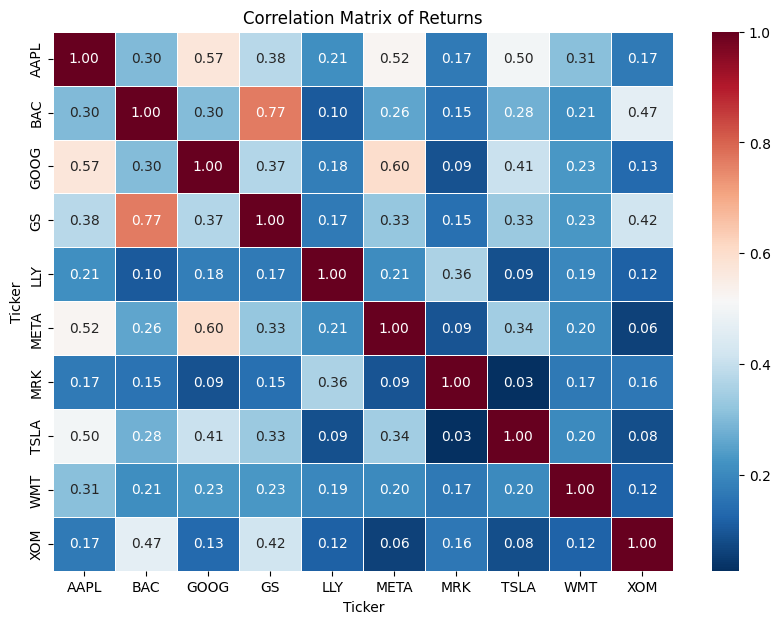

In [7]:
plt.figure(figsize=(10, 7))
sns.heatmap(rets.corr(), annot=True, cmap='RdBu_r', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Returns")
plt.show()

### Defining parameters

In [8]:
TRADING_DAYS = 252

# annualized expected returns
mu = rets.mean() * TRADING_DAYS

# annualized covariance
Sigma = rets.cov() * TRADING_DAYS   

tickers = rets.columns.tolist()

________
# I. Markowitz Mean-Variance Optimization


## 1. Minimum variance (Efficient Frontier)

Minimize variance for a required expected portfolio return $\mathbb{E}[R_p]$:

$$
\begin{aligned}
\min_{w}\quad & w^T \Sigma\, w 

\quad\quad\quad \text{s.t.} \ &
\begin{cases}
w^T \mu = E[R_p]   \\[6pt]
\mathbf{1}^T w = 1  \\[6pt]
0 \le w_i \le 1
\end{cases}
\end{aligned}$$




## 2. Global Minimum Variance portfolio (GMV)

Minimize variance 

$$
\begin{aligned}
\min_{w}\quad & w^T \Sigma\, w 

\quad\quad\quad \text{s.t.} \ &
\begin{cases}
\mathbf{1}^T w = 1  \\[6pt]
0 \le w_i \le 1  
\end{cases}
\end{aligned}$$


## 3. Tangency portfolio (Maximum Sharpe ratio)

Maximize the Sharpe ratio:

$$
\begin{aligned}
\max_{w}\quad & \dfrac{w^T \mu - r_f}{\sqrt{\,w^T \Sigma\, w\,}} 

\quad\quad\quad \text{s.t.} \ &
\begin{cases}
\mathbf{1}^T w = 1 \\[6pt]
0 \le w_i \le 1  
\end{cases}
\end{aligned}$$


In [9]:
def portfolio_performance(W, mu, cov, rf=0):
    ret = W @ mu
    vol = np.sqrt(W @ cov @ W)
    sharpe = (ret - rf) / vol
    return ret, vol, sharpe

def portfolio_volatility(W, mu, cov):
    return np.sqrt(W @ cov @ W)

def neg_sharpe_ratio(W, mu, cov, rf=0.0):
    ret, vol, _ = portfolio_performance(W, mu, cov, rf)
    return -(ret - rf) / vol

def optimize_portfolio(objective, mu, cov, opt_param, extra_args=()):
    """ Generic optimizer """
    w0 = opt_param['w0']
    bounds = opt_param['bounds']
    constraints = opt_param['constraints']
    
    result = minimize(objective, w0, args=(mu, cov, *extra_args),
                      method='SLSQP', bounds=bounds,
                      constraints=constraints,
                      options={'maxiter':500, 'ftol':1e-9})
    return result.x if result.success else None

In [10]:
def gmv_portfolio(mu, Sigma, opt_param):
    """ GMV Portfolio """
    w = optimize_portfolio(portfolio_volatility, mu, Sigma, opt_param)
    return portfolio_performance(w, mu, Sigma) + (w,)

def tangency_portfolio(mu, Sigma, opt_param, rf=0.0):
    """ Tangency Portfolio """
    w = optimize_portfolio(neg_sharpe_ratio, mu, Sigma, opt_param, extra_args=(rf,))
    return portfolio_performance(w, mu, Sigma, rf) + (w,)

def efficient_frontier(mu, Sigma, opt_param, n_points=100):
    """ Efficient Frontier """
    target_returns = np.linspace(mu.min(), mu.max(), n_points)
    target_vols = []
    for target in target_returns:
        # Add target return as equality constraint
        cons = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w, target=target: w @ mu - target}
        )
        temp_param = opt_param.copy()
        temp_param['constraints'] = cons
        w = optimize_portfolio(portfolio_volatility, mu, Sigma, temp_param)
    # #      vol = np.sqrt(w @ Sigma @ w) if w is not None else np.nan
    # # #     target_vols.append(vol)
    # # # return target_returns, target_vols
        if w is None:
            target_vols.append(np.nan)
        else:
            target_vols.append(np.sqrt(w @ Sigma @ w))

    # NEW: clean out all nan points
    target_returns = np.array(target_returns)
    target_vols    = np.array(target_vols)

    mask = ~np.isnan(target_vols)
    return target_returns[mask], target_vols[mask]

In [11]:
# Constraints and bounds
rf = 0.2
n = len(rets.columns)
min_w, max_w = 0.0, 1.0
opt_param = {
    'w0': np.ones(n) / n,
    'constraints': ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},),
    'bounds': tuple((min_w, max_w) for _ in range(n))
}

# GMV
ret_gmv, vol_gmv, sharpe_gmv, w_gmv = gmv_portfolio(mu, Sigma, opt_param)

# Tangency
ret_tan, vol_tan, sharpe_tan, w_tan = tangency_portfolio(mu, Sigma, opt_param, rf=rf)

# Efficient Frontier
target_returns, target_vols = efficient_frontier(mu, Sigma, opt_param)

In [12]:
portfolios = {
    'GMV': {'Return': ret_gmv, 'Volatility': vol_gmv, 'Sharpe': sharpe_gmv, 'Weights': w_gmv},
    'Tangency': {'Return': ret_tan, 'Volatility': vol_tan, 'Sharpe': sharpe_tan, 'Weights': w_tan}
}

# summary
summary_df = pd.DataFrame({
    'Expected Return': [portfolios[p]['Return'] for p in portfolios],
    'Volatility': [portfolios[p]['Volatility'] for p in portfolios],
    'Sharpe Ratio': [portfolios[p]['Sharpe'] for p in portfolios]
}, index=list(portfolios.keys()))

# Weights DataFrame
weights_df = pd.DataFrame({p: portfolios[p]['Weights'] for p in portfolios}, index=mu.index)

full_summary_df = pd.concat([summary_df, weights_df.T], axis=1)
full_summary_df

,Expected Return,Volatility,Sharpe Ratio,AAPL,BAC,GOOG,GS,LLY,META,MRK,TSLA,WMT,XOM
GMV,0.191272,0.146014,1.309957,0.017208,4.320291e-02,9.165164e-02,0.037854,0.053327,2.993414e-18,0.303017,1.344241e-18,3.298510e-01,0.123888
Tangency,0.375297,0.240962,0.727490,0.000000,1.328602e-17,6.479820e-17,0.201393,0.506654,1.471968e-16,0.000000,1.864008e-01,1.787408e-17,0.105553


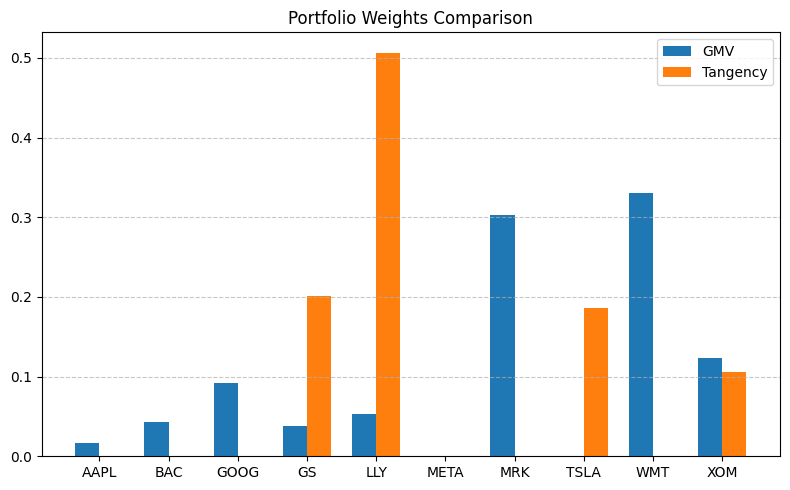

In [13]:
n_assets = weights_df.shape[0]
n_portfolios = weights_df.shape[1]

# Bar positions
x = np.arange(n_assets)
width = 0.35 

plt.figure(figsize=(8, 5))

for i, p in enumerate(weights_df.columns):
    plt.bar(x + i*width, weights_df[p], width=width, label=p)
plt.xticks(x + width*(n_portfolios-1)/2, weights_df.index)
plt.title("Portfolio Weights Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Portfolio with capped weights (20%)

In [14]:
# Constraints and bounds
rf = 0.2
n = len(rets.columns)
min_w, max_w = 0.0, 0.2
opt_param = {
    'w0': np.ones(n) / n,
    'constraints': ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},),
    'bounds': tuple((min_w, max_w) for _ in range(n))
}

# GMV
ret_gmv_cap, vol_gmv_cap, sharpe_gmv_cap, w_gmv_cap = gmv_portfolio(mu, Sigma, opt_param)

# Tangency
ret_tan_cap, vol_tan_cap, sharpe_tan_cap, w_tan_cap = tangency_portfolio(mu, Sigma, opt_param, rf=rf)

# Efficient Frontier
target_returns_cap, target_vols_cap = efficient_frontier(mu, Sigma, opt_param)

KeyboardInterrupt: 

## Efficient Frontier

In [ ]:
def plot_efficient_frontier(target_returns, target_vols, mu, Sigma, 
                            ret_gmv, vol_gmv, ret_tan, vol_tan, sharpe_tan, rf=0.0):
    asset_vols = np.sqrt(np.diag(Sigma))
    asset_returns = mu.values
    tickers_list = mu.index.tolist()

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))

    # Efficient Frontier
    ax.plot(target_vols, target_returns, 'b-', linewidth=2, label='Efficient Frontier')

    # Capital Market Line (CML)
    cml_x = np.linspace(0, max(vol_tan, max(target_vols))*1.1, 100)
    cml_y = rf + sharpe_tan * cml_x
    ax.plot(cml_x, cml_y, 'b--', linewidth=2, label='Capital Market Line (CML)')
    # Tangency Portfolio
    ax.plot(vol_tan, ret_tan, 'b*', markersize=15, label='Tangency Portfolio')
    # GMV Portfolio
    ax.plot(vol_gmv, ret_gmv, 'D', color='blue', markersize=10, label='GMV Portfolio')

    # Individual assets
    ax.scatter(asset_vols, asset_returns, c='black', s=50, label='Assets')
    for i, txt in enumerate(tickers_list):
        ax.text(asset_vols[i]*1.01, asset_returns[i]*1.01, txt, fontsize=9)
    ax.set_title(f'Efficient Frontier (Rf = {rf})')
    ax.set_xlabel('Annualized Volatility')
    ax.set_ylabel('Annualized Return')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    return fig



def add_frontier(fig, frontier_returns, frontier_vols, ret_gmv=None,
    vol_gmv=None, ret_tan=None, vol_tan=None, sharpe_tan=None, rf=None,
    label_frontier="New Frontier", color_frontier=None
):
    ax = fig.axes[0]
    ax.plot(frontier_vols, frontier_returns, linewidth=2,
            label=label_frontier, color=color_frontier 
    )

    # --- GMV ---
    if ret_gmv is not None and vol_gmv is not None:
        ax.scatter(vol_gmv, ret_gmv, s=80, marker='D', color=color_frontier)
    # --- Tangency ---
    if ret_tan is not None and vol_tan is not None:
        ax.scatter(vol_tan, ret_tan, s=90, marker='o', color=color_frontier)

    # --- CML ---
    if rf is not None and sharpe_tan is not None:
        max_vol = max(
            max(frontier_vols),
            vol_tan if vol_tan is not None else 0
        ) * 1.2
        cml_x = np.linspace(0, max_vol, 100)
        cml_y = rf + sharpe_tan * cml_x
        ax.plot(cml_x, cml_y, linestyle='--', linewidth=2, color=color_frontier)

    ax.legend()
    return fig

In [ ]:
fig = plot_efficient_frontier(target_returns, target_vols, mu, Sigma,
                              ret_gmv, vol_gmv, ret_tan, vol_tan, sharpe_tan, rf=rf)

fig = add_frontier(fig, target_returns_cap, target_vols_cap,
    label_frontier="Frontier with 20% capped weight", color_frontier='red',
    vol_gmv=vol_gmv_cap, ret_gmv=ret_gmv_cap,
    vol_tan=vol_tan_cap, ret_tan=ret_tan_cap,
    sharpe_tan=sharpe_tan_cap, rf=rf,
)

plt.show()

## Backtesting

In [ ]:
def cumulative_portfolio_returns(weights, returns_df):
    """Compute cumulative returns of a portfolio"""
    port_ret = returns_df @ weights
    cum_ret = (1 + port_ret).cumprod()
    return cum_ret

# 1/n portfolio
w_eq = np.ones(len(tickers)) / len(tickers)

# Compute cumulative returns
cum_gmv = cumulative_portfolio_returns(w_gmv, returns_all)
cum_tan = cumulative_portfolio_returns(w_tan, returns_all)
cum_eq  = cumulative_portfolio_returns(w_eq, returns_all)
cum_gmv_cap = cumulative_portfolio_returns(w_gmv_cap, returns_all)
cum_tan_cap = cumulative_portfolio_returns(w_tan_cap, returns_all)

# --- Plot ---
plt.figure(figsize=(14,7))
plt.plot(cum_gmv, label='GMV Portfolio', linewidth=1.5)
plt.plot(cum_tan, label='Tangency Portfolio', linewidth=1.5)
plt.plot(cum_eq, label='Equally Weighted', linewidth=1.5)
plt.plot(cum_gmv_cap, label='GMV Portfolio (Capped)', linewidth=1.5)
plt.plot(cum_tan_cap, label='Tangency Portfolio (Capped)', linewidth=1.5)

# --- Shade train and test periods ---
plt.axvspan(cum_gmv.index.min(), pd.to_datetime(test_start_date),
            color='lightblue', alpha=0.2, label='Train Period')
plt.axvspan(pd.to_datetime(test_start_date), cum_gmv.index.max(),
            color='lightcoral', alpha=0.2, label='Test Period')

# Marking start of test period
plt.axvline(pd.to_datetime(test_start_date), color='black', linestyle='--', linewidth=2)
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()